# Inference script for Imagenet models

This notebook can be used for inference on onnx networks trained on **Imagenet** datasets. The demo shows how to use the trained models to do inference in MXNet. Please install the packages if not istalled and MXNet version required for GPU usage.

In [ ]:
# Install dependencies
!pip install mxnet-cu90mkl #tested on this version, can use other versions
!pip install numpy
!pip install matplotlib

In [7]:
#import required packages
import mxnet as mx
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from collections import namedtuple
from mxnet.gluon.data.vision import transforms
from mxnet.contrib.onnx._import.import_model import import_model

Before moving to next section make sure that you have the image required for inference. 
For demo,we have used kitten image from S3 bucket which can be obtained using thh following command.
"curl -O https://s3.amazonaws.com/model-server/inputs/kitten.jpg".
Also make sure to have the labels/synset on which the network was trained.
We are using mxnet to do this inference and hence we will export to MXnet as shown below.

In [ ]:
##Import from ONNX format to Mxnet syms and params
#model path is the path to the onnx file for the model being using for inference
model_path= 'vgg16.onnx'
sym, arg_params, aux_params = import_model(model_path)

In [13]:
##Required to be done in case of syms and params present
## Bind symbols and params 
## synset file to be in the working directory
model_name = 'vgg/vgg16'
sym, arg_params, aux_params = mx.model.load_checkpoint(model_name, 0)

In [14]:
##Load the network for inference
ctx = mx.gpu(0)
mod = mx.mod.Module(symbol=sym, context=ctx, label_names=None)
mod.bind(for_training=False, data_shapes=[('data', (1,3,224,224))], 
         label_shapes=mod._label_shapes)
mod.set_params(arg_params, aux_params, allow_missing=True, allow_extra=True)

In [15]:
## Read the imagenet labels on which network was trained
with open('synset.txt', 'r') as f:
    labels = [l.rstrip() for l in f]

In [18]:
Batch = namedtuple('Batch', ['data'])

def get_image(path, show=False):
    '''read and show the image taking the path as input
    '''
    img = mx.image.imread(path)
    if img is None:
        return None
    if show:
        plt.imshow(img.asnumpy())
        plt.axis('off')
    return img
   
def preprocess(img):   
    '''
    Preprocessing required on the images for inference
    '''
    
    transform_fn = transforms.Compose([
    transforms.Resize(224),
    #transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    img = transform_fn(img)
    img = img.expand_dims(axis=0) # batchify
    
    return img

def predict(path):
    '''
    Takes path of the input image and flag to display input image and prints 5 top predictions
    '''
    img = get_image(path, show=True)
    img = preprocess(img)
    mod.forward(Batch([img]))
    scores = mx.ndarray.softmax(mod.get_outputs()[0]).asnumpy()
    # print the top-5 inferences class
    scores = np.squeeze(scores)
    a = np.argsort(scores)[::-1]
    for i in a[0:5]:
        print('class=%s ; probability=%f' %(labels[i],scores[i]))

class=n02124075 Egyptian cat ; probability=0.320931
class=n02123045 tabby, tabby cat ; probability=0.295768
class=n02127052 lynx, catamount ; probability=0.212184
class=n02123159 tiger cat ; probability=0.135281
class=n02123394 Persian cat ; probability=0.014649


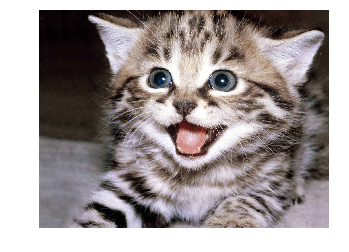

In [19]:
#img_path is the path of the inference image
img_path = 'sqnet/kitten.jpg'
predict(img_path)